In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext watermark
%watermark -p torch,pandas,numpy -m

torch 0.4.1
pandas 0.22.0
numpy 1.15.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from pathlib import Path
import itertools
from collections import Counter
from functools import partial, reduce

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from fastai.text import (
    TextDataset, SortishSampler, SortSampler, DataLoader, ModelData, get_rnn_classifier, seq2seq_reg, 
    RNN_Learner, TextModel, to_gpu, LanguageModelLoader, LanguageModelData
)
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from fastai.text import accuracy
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import sentencepiece as spm

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
path = Path("../data/cache/lm_unigram_douban/")
path.mkdir(parents=True, exist_ok=True)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import And Tokenize Comments and Ratings

In [6]:
df_ratings = pd.read_csv("../data/ratings_word.csv")
df_ratings.head()

,comment,rating
0,别 拿 矫揉造作 的 资产阶级 情调 麻醉 中国 人民 ！,1
1,文青 们 向往 的 生活 ， 可是 生活 中 没有 了 喜怒哀乐 ， 没有 了 问题 与 冲...,2
2,自由 也许 在 大理 ， 生活 确实 在 别处 。,3
3,原来 八旬 是 小四 的 老公 ， 小 彩旗 的 爹 ， 杨丽萍 的 妹夫 。,3
4,关于 大理 的 蓝光 旅游 宣传片 。,3


In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=888)
train_idx, test_idx = next(sss.split(df_ratings, df_ratings.rating))
df_train = df_ratings.iloc[train_idx].copy()
df_test = df_ratings.iloc[test_idx].copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=888)
val_idx, test_idx = next(sss.split(df_test, df_test.rating))
df_val = df_test.iloc[val_idx].copy()
df_test = df_test.iloc[test_idx].copy()
del df_ratings

In [8]:
UNK = 0
BEG = 1
EMB_DIM = 300

### Use the Unigram Vocabulary from the Wiki model

In [9]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/unigram_model.model")

True

#### Tokenize

In [11]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + sp.EncodeAsIds(row["comment"])))

In [12]:
assert len(tokens_train) == df_train.shape[0]

In [14]:
tokens_train[0]

array([   1,   17,  265,  226, 3354,   28,  603,  956, 5043,    3,  410,   11,  218, 2900,  133,   17, 4569,
       5471,  381,    5,  133, 1670,   12,   68, 3781, 4228, 6047,    4, 4569, 6521,    3, 2937, 2376,   29,
         17,   15,    3,   40, 4452,  198,  265,   15, 1226,    5])

#### Embedding
We can keep using the original embedding matrix, but the row corresponding to the BEG token must be zeroed.

In [17]:
MODEL_PATH = "../data/cache/lm_unigram/models/lm_lstm.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.encoder.weight'].shape[1] == EMB_DIM
weights['0.encoder.weight'].shape

torch.Size([7500, 300])

In [18]:
weights['0.encoder.weight'][BEG, :] = 0
weights['0.encoder_with_dropout.embed.weight'][BEG, :] = 0
weights['1.decoder.weight'][BEG, :] = 0

In [22]:
n_toks = weights['0.encoder.weight'].shape[0]

### Use the Refitted Vocabulary
#### Investigate Vocabulary Differences

In [9]:
itos_orig = []
with open("../data/unigram_model.vocab", mode="r", encoding="utf-8") as f:
    for line in f.readlines():
        itos_orig.append(line.split("\t")[0])
itos = []
with open("../data/rating_unigram_model.vocab", mode="r", encoding="utf-8") as f:
    for line in f.readlines():
        itos.append(line.split("\t")[0])
n_toks = len(itos)
n_toks

7500

In [10]:
itos[:5]

['<unk>', '<s>', '</s>', '▁,', '▁的']

In [11]:
mapping = {s: idx for idx, s in enumerate(itos)}
mapping_orig = {s: idx for idx, s in enumerate(itos_orig)}

In [12]:
voc_diff = set(itos) - set(itos_orig)
print(len(voc_diff), len(itos))
sorted([(x, mapping[x]) for x in list(voc_diff)], key=lambda x: x[1], reverse=True)[:50]

2823 7500


[('婪', 7499),
 ('★', 7491),
 ('】', 7490),
 ('兀', 7489),
 ('☆', 7488),
 ('葩', 7487),
 ('̄', 7486),
 ('喂', 7485),
 ('咱', 7484),
 ('匆', 7482),
 ('蝴', 7478),
 ('袱', 7477),
 ('寥', 7476),
 ('疙', 7475),
 ('痨', 7474),
 ('【', 7470),
 (']', 7469),
 ('*', 7468),
 ('扔', 7466),
 ('窒', 7464),
 ('漓', 7462),
 ('肮', 7459),
 ('@', 7458),
 ('[', 7457),
 ('驭', 7455),
 ('渲', 7453),
 ('樟', 7452),
 ('跪', 7451),
 ('甩', 7448),
 ('噱', 7445),
 ('暧', 7440),
 ('谑', 7439),
 ('蹩', 7435),
 ('讶', 7434),
 ('戛', 7431),
 ('╭', 7428),
 ('娴', 7423),
 ('蹋', 7422),
 ('疵', 7403),
 ('潇', 7401),
 ('尴', 7400),
 ('烘', 7390),
 ('陌', 7383),
 ('馨', 7381),
 ('瑕', 7377),
 ('>', 7373),
 ('唏', 7372),
 ('俐', 7371),
 ('谬', 7369),
 ('缚', 7359)]

#### Tokenize

In [13]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/rating_unigram_model.model")

True

In [14]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + sp.EncodeAsIds(row["comment"])))
assert len(tokens_train) == df_train.shape[0]        

In [15]:
tokens_val[0]

array([   1,  163,  149,   99, 1064, 1412])

In [16]:
df_val.iloc[0]

comment    男 主角 像 卡卡
rating             2
Name: 681247, dtype: object

#### Prepare the embedding matrix

In [17]:
MODEL_PATH = "../data/cache/lm_unigram/models/lm_lstm.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.encoder.weight'].shape[1] == EMB_DIM
weights['0.encoder.weight'].shape

torch.Size([7500, 300])

In [18]:
new_matrix = np.zeros((n_toks, EMB_DIM))
hits = 0
for i, w in enumerate(itos):
    if w in mapping_orig:
        new_matrix[i] = weights['0.encoder.weight'][mapping_orig[w]]
        hits += 1
new_matrix[BEG, :] = 0
hits, hits *100 / len(itos[3:])

(4677, 62.38495398159264)

In [19]:
weights['0.encoder.weight'] = T(new_matrix)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_matrix))
weights['1.decoder.weight'] = T(np.copy(new_matrix))

## Languange Model

In [20]:
bs = 64
bptt = 50
trn_dl = LanguageModelLoader(np.concatenate(tokens_train), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(tokens_val), bs, bptt)

In [21]:
np.max(np.array(list(itertools.chain.from_iterable(tokens_train))))

7490

In [23]:
model_data = LanguageModelData(path, 2, n_toks, trn_dl, val_dl, bs=bs, bptt=bptt)

In [24]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
opt_fn = partial(torch.optim.Adam, betas=(0.8, 0.99))

In [25]:
learner = model_data.get_model(opt_fn, EMB_DIM, 500, 3, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [26]:
learner.model.load_state_dict(weights)

In [27]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=1e-7, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      5.577481   5.377635   0.168046  



[5.377635119494657, 0.1680461146952847]

In [28]:
learner.save('lm_last_ft')

In [29]:
learner.unfreeze()
learner.clip = 25
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      5.157025   4.966034   0.200338  



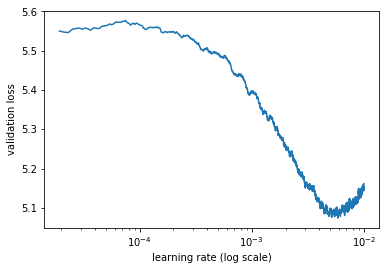

In [30]:
learner.sched.plot()

In [31]:
lr = 3e-3
lrs = lr
learner.fit(lrs, 1, wds=1e-7, use_clr=(20,5), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                     
    0      5.004644   4.810403   0.215846  
    1      4.888845   4.690563   0.225409                     
    2      4.812634   4.619514   0.232305                     
    3      4.74716    4.575836   0.23663                      
    4      4.719796   4.541729   0.239888                     
    5      4.676504   4.511105   0.24359                      
    6      4.649265   4.486551   0.24584                      
    7      4.619393   4.464896   0.248276                     
    8      4.599483   4.446389   0.250157                     
    9      4.584525   4.432842   0.251815                     



[4.432841840593756, 0.2518151349175449]

In [34]:
learner.save_encoder("lm1_enc")

In [35]:
learner.save("lm1")

In [36]:
del learner

## 3-class Classifier
As in https://zhuanlan.zhihu.com/p/27198713

### Full Dataset (v1)

In [37]:
for df in (df_train, df_val, df_test):
    df["label"] = (df["rating"] >= 3) * 1
    df.loc[df.rating == 3, "label"] = 1
    df.loc[df.rating > 3, "label"] = 2

In [38]:
df_train.label.value_counts()

2    240094
1    184124
0    104406
Name: label, dtype: int64

In [39]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.label.values)
val_ds = TextDataset(tokens_val, df_val.label.values)
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [40]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [41]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=2,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [42]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 82%|████████▏ | 13521/16520 [02:40<00:35, 84.20it/s, loss=3.04] 

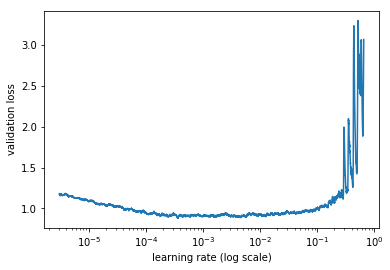

In [43]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [44]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                         
    0      0.884187   0.844602   0.599309  


[0.8446015893065355, 0.5993087714519204]

In [45]:
learn.save('clas_0')

In [46]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.889135   0.83309    0.606091  


[0.8330896465327838, 0.6060905293743757]

In [47]:
learn.save('clas_1')

In [48]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                        
    0      0.87336    0.821222   0.610977  
    1      0.841587   0.8015     0.624909                        
    2      0.829036   0.788889   0.63244                         
    3      0.814548   0.784089   0.634529                        
    4      0.808048   0.77581    0.63963                         
    5      0.805943   0.772495   0.640896                        
    6      0.793054   0.769689   0.642423                        
    7      0.797281   0.767278   0.644267                        
    8      0.780281   0.76666    0.644579                        
    9      0.81333    0.767201   0.644085                        
    10     0.795573   0.763356   0.645987                        
    11     0.785277   0.766877   0.644914                        
    12     0.804006   0.761355   0.647326                        
    13     0.801202   0.761603   0.646702                        


[0.7616032683198787, 0.6467016253518569]

In [49]:
learn.save("clas_full")

#### Evaluate

In [50]:
learn.load("clas_full")
learn.model.reset()
_ = learn.model.eval()

In [51]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(val_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [52]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176208,), (176208,))

In [53]:
pd.Series(ys).value_counts()

2    80031
1    61374
0    34803
dtype: int64

In [54]:
pd.Series(preds).value_counts()

2    92847
1    51618
0    31743
dtype: int64

In [55]:
np.sum(ys==preds) / ys.shape[0]

0.6467016253518569

In [56]:
np.where(ys==0)

(array([    12,     15,     18, ..., 176198, 176202, 176207]),)

In [57]:
tokens_val[176196]

array([   1,  296,    4, 5142,    3, 1195,   13,   20,   16,    5, 3497,  326,    8,    3,   15,   82,  179])

In [58]:
sp.DecodeIds(tokens_val[176196].tolist()), df_val["comment"].iloc[176196]

('如此 的 欺骗 , 或许 我 也 就 释然 了 , 有 什么 呢', '如此 的 欺骗 ， 或许 我 也 就 释然 了 ， 有 什么 呢')

In [59]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()

In [60]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

array([[ 0.81372,  0.50976, -0.36634]], dtype=float32)

In [61]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

array([[-2.24729, -1.05744,  1.79974]], dtype=float32)

In [62]:
get_prediction("说 实话 我 没 怎么 认真 看 ， 电影院 里 的 熊 孩子 太 闹腾 了 ， 前面 的 小奶娃 还 时不时 站 "
               "在 老爸 腿上 蹦迪 ， 观影 体验 极差 ， 不过 小朋友 应该 挺 喜欢 的")

array([[-0.17188,  0.76937, -0.28284]], dtype=float32)

In [63]:
get_prediction("这 电影 太 好笑 了 ， 说好 的 高科技 人才 研制 的 产品 永远 在 关键 时候 失灵 "
               "； 特地 飞 到 泰国 请来 救援 人才 ， 大家 研究 出 的 方法 每次 都是 先 给 鲨鱼 "
               "当 诱饵 … … 显然 这样 的 对战 坚持不了 多久 ， 只能 赶紧 让 鲨鱼 输 了 。")

array([[-1.61565, -0.25882,  1.13853]], dtype=float32)

In [64]:
get_prediction("太 接地气 了 ， 在 三亚 煮饺子 式 的 景区 海域 ， 冒出来 一条 大 鲨鱼 "
               "… … 爽点 也 很 密集 ， 郭达森 与 李冰冰 的 CP 感 不错 ， 编剧 果然 是 "
               "老外 ， 中文 台词 有点 尬 。")

array([[-0.94944,  0.44604, -0.08478]], dtype=float32)

In [65]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

array([[-0.16678,  0.35306, -0.27641]], dtype=float32)

In [66]:
get_prediction("太 难 了 。 。 。")

array([[ 1.24439,  0.64315, -0.77132]], dtype=float32)

In [67]:
get_prediction("把 我 基神 写成 智障 ， 辣鸡 mcu")

array([[ 0.99737, -0.48013, -0.02205]], dtype=float32)

In [68]:
get_prediction("鲨鱼 部分 还是 不错 的 ， 尤其 是 中段 第一次 出海 捕鲨 非常 刺激 ， 其后 急速 下滑 ， "
               "三亚 那 部分 拍得 是什么 鬼 。 。 。 爆米花 片 可以 适度 的 蠢 ， 但 人类 反派 炸鲨 "
               "和 直升机 相撞 部分 简直 蠢得 太过份 了 吧 ？ 另外 充满 硬 加戏 视感 的 尴尬 感情戏 "
               "把 节奏 也 拖垮 了 ， 明明 可以 更 出色 ， 却 很遗憾 地 止步 在 马马虎虎 的 水平 。 6 / 10")

array([[ 0.46175,  1.35265, -1.97814]], dtype=float32)

In [69]:
get_prediction("老冰冰 真的 很努力 ！ 为 老冰冰 实现 了 她 的 好莱坞 女主梦 鼓掌 . . .")

array([[-1.64013, -0.14092,  1.10669]], dtype=float32)

In [70]:
get_prediction("结局 简直 丧 出 天际 ！ 灭霸 竟然 有 内心戏 ！ 全程 下来 美队 "
               "和 钢铁侠 也 没 见上 一面 ， 我 还 以为 在 世界 末日 前 必然 "
               "要 重修 旧好 了 ！ ")

array([[-0.54731, -0.02726,  0.20957]], dtype=float32)

In [71]:
get_prediction("太 烂 了 ， 难看 至极 。")

array([[ 4.0647 , -0.66184, -1.75789]], dtype=float32)

In [72]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

array([[ 0.85817,  0.47482, -0.78418]], dtype=float32)

In [73]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

array([[ 1.10744,  0.5297 , -1.10803]], dtype=float32)

In [74]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

array([[ 0.18292, -0.27182,  0.24647]], dtype=float32)

In [75]:
get_prediction("还 我 电影票 14 元")

array([[ 1.06886, -0.09724,  0.11563]], dtype=float32)

Confusion matrix, without normalization
[[20378  9302  5123]
 [ 8418 29404 23552]
 [ 2947 12912 64172]]


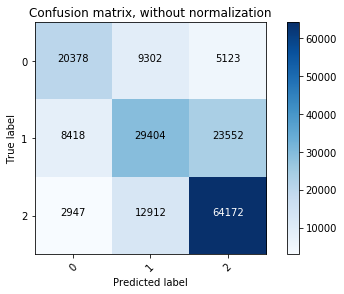

In [76]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.59 0.27 0.15]
 [0.14 0.48 0.38]
 [0.04 0.16 0.8 ]]


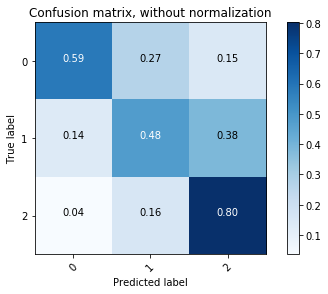

In [77]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [78]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 64%, R 59%, FS 0.61, Support: 34803
Class 1: P 57%, R 48%, FS 0.52, Support: 61374
Class 2: P 69%, R 80%, FS 0.74, Support: 80031


In [79]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [80]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [81]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [82]:
np.sum(ys==preds) / ys.shape[0]

0.6463461003694476

Confusion matrix, without normalization
[[20103  9456  5243]
 [ 8442 29518 23415]
 [ 2908 12853 64271]]


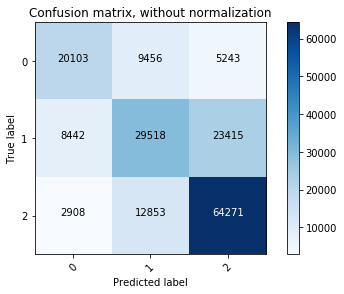

In [83]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.58 0.27 0.15]
 [0.14 0.48 0.38]
 [0.04 0.16 0.8 ]]


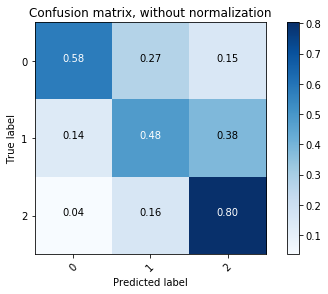

In [84]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [85]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 64%, R 58%, FS 0.61, Support: 34802
Class 1: P 57%, R 48%, FS 0.52, Support: 61375
Class 2: P 69%, R 80%, FS 0.74, Support: 80032


### Smaller Dataset 

In [86]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [87]:
df_train_small = pd.concat([
    df_train[df_train.label==0].sample(15000),
    df_train[df_train.label==1].sample(15000),
    df_train[df_train.label==2].sample(15000)
], axis=0)
df_val_small = pd.concat([
    df_val[df_val.label==0].sample(5000),
    df_val[df_val.label==1].sample(5000),
    df_val[df_val.label==2].sample(5000)
], axis=0)

In [88]:
np.array(df_train_small.index)

array([172194, 370706,  16474, ...,    999, 118848, 302932])

In [89]:
bs = 64
tokens_train_small = np.array(tokens_train)[np.array(df_train_small.index)]
tokens_val_small = np.array(tokens_val)[np.array(df_val_small.index)]
trn_ds = TextDataset(tokens_train_small, df_train_small.label.values)
val_ds = TextDataset(tokens_val_small, df_val_small.label.values)
trn_samp = SortishSampler(tokens_train_small, key=lambda x: len(tokens_train_small[x]), bs=bs//2)
val_samp = SortSampler(tokens_val_small, key=lambda x: len(tokens_val_small[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [90]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [91]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [92]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 82%|████████▏ | 1153/1407 [00:14<00:03, 82.20it/s, loss=3.86]

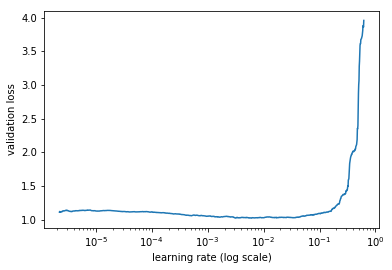

In [93]:
learn.freeze_to(-1)
learn.lr_find(lrs/100)
learn.sched.plot()

In [94]:
lr=1e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      1.008255   0.911152   0.560067  


[0.9111515250841776, 0.560066666730245]

In [95]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.981435   0.904076   0.563     


[0.9040763699531555, 0.5630000000317892]

In [96]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.986445   0.897079   0.568     
    1      0.969528   0.883052   0.578333                      
    2      0.963595   0.869589   0.584867                      
    3      0.937584   0.865238   0.586733                      
    4      0.935019   0.864455   0.589533                      
    5      0.926273   0.860759   0.5912                        
    6      0.923473   0.859153   0.5922                        
    7      0.903564   0.855341   0.593867                      
    8      0.925118   0.850956   0.600333                      
    9      0.906861   0.853416   0.596667                      
    10     0.902489   0.854341   0.5964                        
    11     0.886815   0.849023   0.599933                      
    12     0.893847   0.849745   0.5966                        
    13     0.899159   0.847769   0.6014                        


[0.847769185034434, 0.6014000000635783]

In [97]:
learn.save("clas_small_full")

In [98]:
learn.model.eval()
preds, ys = [], []
for x, y in val_dl:
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [99]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((15000,), (15000,))

Normalized confusion matrix
[[0.68 0.19 0.13]
 [0.24 0.41 0.35]
 [0.1  0.19 0.72]]


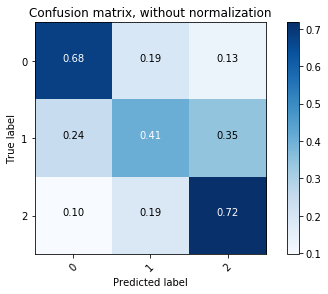

In [100]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [101]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [102]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [103]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [104]:
np.sum(preds==ys) / preds.shape[0]

0.6006730643724214

Normalized confusion matrix
[[0.67 0.19 0.13]
 [0.25 0.4  0.35]
 [0.1  0.18 0.72]]


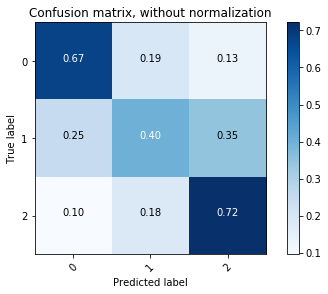

In [105]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [106]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 50%, R 67%, FS 0.58, Support: 34802
Class 1: P 54%, R 40%, FS 0.46, Support: 61375
Class 2: P 69%, R 72%, FS 0.71, Support: 80032


## Regressor

In [107]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.rating.values.astype("float32"))
val_ds = TextDataset(tokens_val, df_val.rating.values.astype("float32"))
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [108]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [109]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 1], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [110]:
class RNN_RegLearner(RNN_Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return lambda x, y: F.mse_loss(x[:, 0], y)

In [111]:
learn = RNN_RegLearner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = []
learn.load_encoder('lm1_enc')

In [112]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

 80%|███████▉  | 13165/16520 [02:44<00:41, 80.05it/s, loss=3.58] 

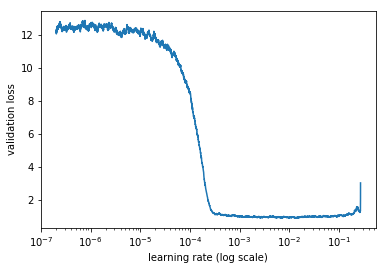

In [113]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [114]:
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_0')

epoch      trn_loss   val_loss                                    
    0      0.906491   0.806622  


In [115]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_1')

epoch      trn_loss   val_loss                                   
    0      0.85863    0.78094   


In [116]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))
learn.save('reg_full')

epoch      trn_loss   val_loss                                   
    0      0.840117   0.766736  
    1      0.818093   0.726338                                   
    2      0.806031   0.709372                                   
    3      0.775895   0.69642                                    
    4      0.756379   0.689876                                   
    5      0.746213   0.680605                                   
    6      0.740827   0.677815                                   
    7      0.753874   0.677036                                   
    8      0.773144   0.675859                                   
    9      0.750596   0.670305                                   
    10     0.71643    0.671012                                   
    11     0.743645   0.671412                                   
    12     0.754897   0.669753                                   
    13     0.716792   0.667246                                   


In [119]:
# Export Model
torch.save(learn.model, path / "sentiment_model.pth")

In [120]:
learn.load('reg_full')

### Evaluation

In [121]:
test_ds = TextDataset(tokens_test, df_test.rating.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [122]:
def get_preds(data_loader):
    learn.model.eval()
    learn.model.reset()         
    preds, ys = [], []
    for x, y in tqdm_notebook(data_loader):   
        preds.append(learn.model(x)[0].cpu().data.numpy()[:, 0])
        ys.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    return ys, preds
ys, preds = get_preds(val_dl)
preds.shape, ys.shape

((176208,), (176208,))

In [123]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [124]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [125]:
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6672458383699945

In [126]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6645135826693453

In [127]:
# Save predictions
df_val.loc[df_val.iloc[list(iter(val_samp))].index, "preds"] = preds
df_val.to_csv(path / "df_val.csv.gz", index=False, compression="gzip")
df_val.head()

,comment,rating,label,preds
0,男 主角 像 卡卡,2,0,3.259298
1,经典 改编 ， 还是 忠于 原著 的 ， 一路 都 很 稳 。,4,2,3.962335
2,叙事 ： 时间 空间 的 有机 结合,5,2,3.984771
3,看 街头 小 混混 打 外星人 挺 热闹 的 ， 可是 前 一 秒 还 在 抢劫 的 少年犯...,2,0,2.617926
4,这 电影 也 就 一般,3,1,2.664217


In [128]:
np.sum(np.square(df_val.rating.values - df_val.preds.values)) / preds.shape[0]

0.6645136139748985

In [129]:
ys, preds = get_preds(test_dl)
preds.shape, ys.shape

((176209,), (176209,))

In [130]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6696406409027693

In [131]:
# Save predictions
df_test.loc[df_test.iloc[list(iter(test_samp))].index, "preds"] = preds
df_test.to_csv(path / "df_test.csv.gz", index=False, compression="gzip")
df_test.head()

,comment,rating,label,preds
258461,无话可说 .,3,1,2.793769
118491,老师 你 太 可爱,5,2,3.972624
44768,说 了 好多 话 ， 可惜 都 是 陈词滥调 、 无 凭 无据 。,2,0,2.899381
34630,普巴 家用 的 电脑 是 苹果 。,3,1,3.418046
382761,这 才 是 一 部 看 完 之后 观众 讲 不 清道 不 明 的 电影 ， 主线 不 明了 ...,4,2,3.353409


In [132]:
df_test.sample(20)

,comment,rating,label,preds
842390,初中 的 时候 看 了 一 堆 007 的 VCD 。,3,1,3.232347
627523,现在 还 记得 张铁林 扮演 的 怡 亲王 。 。 。,5,2,3.298126
624264,一般 般,3,1,2.779430
113664,我 的 天 Higgs 已经 是 两 年 多 之前 的 事情 了 ................,5,2,4.072724
159047,在 不 知道 是 俄语 字幕 还是 爪 哇语 字幕 的 干扰 下 ， 欢快 的 啃生 肉 啃...,4,2,1.821184
219821,切入点 选 得 好 ， 反 高潮 ， 去 戏剧化 ， 斯皮尔伯格 难得 这么 克制 ， 只是...,4,2,3.595191
667673,几 个 细节 ： 1. 嫌犯 被捕 时 被 通知不宣 读 个人 权利 ， 审问 时 没有 律...,4,2,3.452877
637800,灰暗 ， 低沉 。,3,1,3.352764
258851,2.5 吧 。 看 在 老屈 的 面子 四 舍 五 入 一下 。 实在 是 一 部 类似 疾...,3,1,2.796375
594371,没 看 过 ， 但是 我 看 过 一些 数典忘祖 的 美 狗 日杂 ， 所以 五星,5,2,5.000000


In [133]:
np.sum(np.square(df_test.rating.values - df_test.preds.values)) / preds.shape[0]

0.6696406409027692

In [134]:
preds_class = np.round(preds)

Confusion matrix, without normalization
[[ 2295  4783  3571   831    42]
 [  928  8134 11832  2369    17]
 [  138  5062 35945 20023   207]
 [   19   758 15338 36985  1549]
 [   24   286  3694 18211  3168]]


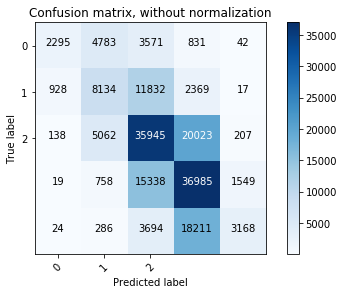

In [135]:
cnf_matrix = confusion_matrix(ys, preds_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

In [136]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds_class)
for i in range(5):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 67%, R 20%, FS 0.31, Support: 11522
Class 1: P 43%, R 35%, FS 0.38, Support: 23280
Class 2: P 51%, R 59%, FS 0.55, Support: 61375
Class 3: P 47%, R 68%, FS 0.56, Support: 54649
Class 4: P 64%, R 12%, FS 0.21, Support: 25383


In [137]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()[0, 0]

In [138]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

2.5044014

In [139]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

4.534949

In [140]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

2.3158228

In [141]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

3.0249376

In [142]:
get_prediction("太 烂 了 ， 难看 至极 。")

1.3973805

In [143]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

2.4281068

In [144]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

3.234384

In [145]:
get_prediction("还 我 电影票 14 元")

2.522077